## Bayesian Optimisation with different Kernels

In this notebook, we will see how to change the Kernel of the Gaussian Process.

- [Kernels for Gaussian Processes](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes)

- [GaussianProcessRegressor](https://scikit-optimize.github.io/stable/modules/generated/skopt.learning.GaussianProcessRegressor.html)

- [Test different Kernels example from Scikit-Optimize](https://scikit-optimize.github.io/stable/auto_examples/optimizer-with-different-base-estimator.html#test-different-kernels)

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

# squared exponential kernel
from sklearn.gaussian_process.kernels import RBF

from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

# Gaussian Process Regressor, we will change the kernel here:
from skopt.learning import GaussianProcessRegressor

In [2]:
# load dataset
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# the target:
# percentage of benign (0) and malign tumors (1)

y.value_counts() / len(y)

0    0.627417
1    0.372583
Name: count, dtype: float64

In [4]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

## Define the Hyperparameter Space

Scikit-optimize provides an utility function to create the range of values to examine for each hyperparameters. More details in [skopt.Space](https://scikit-optimize.github.io/stable/modules/generated/skopt.Space.html)

In [29]:
# define the hyperparam space

param_grid = [
    Integer(10, 120, name="n_estimators"),
    Real(0, 0.999, name="min_samples_split"),
    Integer(1, 5, name="max_depth"),
    Categorical(["log_loss", "exponential"], name="loss")
]

## Define the model

In [30]:
# setup the gradient boosting classifier

gbm = GradientBoostingClassifier(random_state=0)

## Define the Kernel

[RBF](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html#sklearn.gaussian_process.kernels.RBF)

In [31]:
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
kernel

1**2 * RBF(length_scale=1)

## Setup the Gaussian Process

In [32]:
gpr = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    noise="gaussian",
    n_restarts_optimizer=1
)

## Define the objective function

This is the hyperparameter response space, the function we want to minimize.

In [33]:
# We design a function to maximize the accuracy, of a GBM,
# with cross-validation

# the decorator allows our objective function to receive the parameters as
# keyword arguments. This is a requirement of Scikit-Optimize.
@use_named_args(param_grid)
def objective(**params) -> float:
    # set the model params
    gbm.set_params(**params)
    
    # optimization function (hyperparam response function)
    value = np.mean(
        cross_val_score(
            gbm,
            X_train,
            y_train,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
    )
    
    # negate because we need to minimize
    return -value

## Bayesian Optimization

We are now ready for sequential model-based optimization. Here we use Gaussian process-based Optimization.

In [34]:
gp_ = gp_minimize(
    objective,
    dimensions=param_grid,
    base_estimator=gpr,
    n_initial_points=5,
    acq_optimizer="sampling",
    random_state=42,
)

In [35]:
# function value at the minimum.
# note that it is the negative of the accuracy

"Best score=%.4f" % gp_.fun

'Best score=-0.9724'

In [36]:
print("""Best parameters:
=========================
- n_estimators=%d
- min_samples_split=%.6f
- max_depth=%d
- loss=%s""" % (gp_.x[0], 
                gp_.x[1],
                gp_.x[2],
                gp_.x[3]))

Best parameters:
- n_estimators=120
- min_samples_split=0.747848
- max_depth=3
- loss=log_loss


## Evaluate convergence of the search

[plot_convergence](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_convergence.html#skopt.plots.plot_convergence)

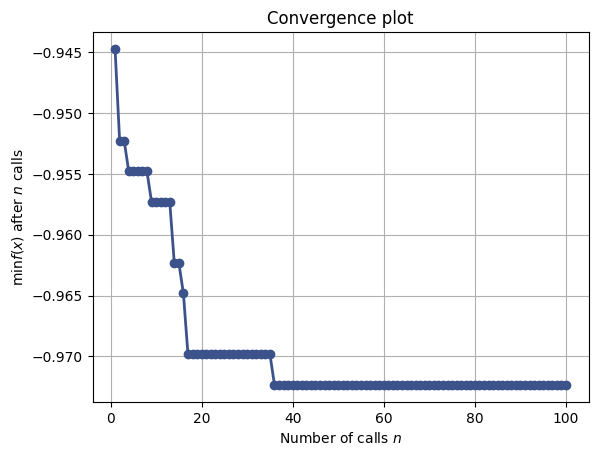

In [38]:
plot_convergence(gp_);

>Note that it needed 80 iterations to find the minimum of the hyperparamter response function using RBF(squared exponential) kernel, whereas with the Marten Kernel, it found it faster.